# Personal Information
Name: **Anh Tran**

StudentID: **12770698**

Email: [**anh.tran1@student.uva.nl**](anh.tran1@student.uva.nl)

Submitted on: **DD.MM.YYYY**

# Data Context

The topic of this research project is to explore gentrification - the process of a neighborhood changing as a result of wealthier residents moving in, bringing investments and physical improvements, but displacing existing residents as prices rise and cultures homogenized or replaced. This project examines the visual indicators of gentrification, more specifically in the signage of storefronts in Amsterdam, by applying computer vision methods on images of facades in the city.

The image dataset used in this project is from the [StreetSwipe project](http://streetswipe.aestheticsofexclusion.com/about.php). Via crowd-sourcing, the project let people decide which facade is gentrified, by voting "Yes" or "No" on the streetview images. The official *gentrified* and *non-gentrified* labels are generated based the majority of votes for each facade. Additionally, if subsequent voters decides against the majority, they are prompted to provide a textual explanation for their vote (mismatch responses).

On this data, scene-text detection will be applied to identify the regions of the images that contain the storefront signage (if any). With the text region extracted (still as an image), font recognition and color extraction will be done to understand these attributes; and text recognition will be applied to extract machine-readable text strings, whose semantic meanings will be studied using word embedding. This pipeline will be applied on gentrified and non-gentrified labelled data, and ultimately the learnt attributes (fonts, colors, semantics) of these classes are compared to understand what is seen as gentrified.

# Data Description

**Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**

As you can see, you are in a jupyter notebook environment here. This means that you should focus little on writing text and more on actually exploring your data. If you need to, you can use the amsmath environment in-line: $e=mc^2$ or also in separate equations such as here:

\begin{equation}
    e=mc^2 \mathrm{\space where \space} e,m,c\in \mathbb{R}
\end{equation}

Furthermore, you can insert images such as your data aggregation diagrams like this:

<!-- ![image](example.png) -->

In [116]:
# Imports
# import os, sys
import shutil 
# import numpy as np
# import pandas as pd
# from glob import glob
# # from bq_helper import BigQueryHelper
# from dask import bag, diagnostics 
# from urllib import request
# import cv2

# from PIL import Image
# from PIL.ExifTags import TAGS

# import glob
# import missingno as msno
# import hvplot.pandas  # custom install
# from matplotlib import pyplot as plt
%matplotlib inline

The data is divided into two subsets, generally called pre-July 2020 and post-July 2020. This is because there are two versions of the StreetSwipe data collection tool. There are 2441 images in total - 1912 images in the older version (pre-July 2020) and 529 in the new one (post-July 2020). While the images from the pre-July 2020 subset are available directly, those from the new version are stored in a Google APIs bucket - these were scraped via the URLs provided by the project owner. Each image has metadata on the facade's location (latitude and longitude) and street name. The new version's images also have more detailed address, name and type of business/services. 

In terms of data generated from StreetSwipe's tool, these are stored in multiple CSV files. All images have corresponding data entries on the numbers of "yes" and "no" votes for gentrification. In addition, each individual response is recorded with an unique response ID, along with the image ID, the vote (yes/no). Lastly, mismatch responses are also recorded with an unique response ID, image ID, the vote (yes/no), and the textual answer given by the voter.

Since the main interest of the research is to learn visual patterns from the labeled facades, the data that will be further processed and discussed in this analysis consists only of the images and the CSV files with votes for each image. These data are loaded below, divided into the pre- and post-July 2020 subsets.

In [132]:
# images = [cv2.imread(file) for file in glob.glob("all_images/*.jpg")]
# images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images] # correct the color channel
# print(f"Total number of images: {len(images)}")

None


### Labels
Below is an overview into the original shape of the main data frames of interest - ones that indicate the number of gentrified/non-gentrified votes per image:

In [118]:
# Load data
# left yes right no
# Pre-July 2020 votes
scores_pre = pd.read_csv("database/pre_202007/ss_afb_scores.csv", names = ['id','yes','no'] )
# Post-July 2020 votes
scores_post = pd.read_csv("database/post_202007/ss_afb_scores.csv", names = ['id','yes','no'] )

print("Pre-July 2020"); print(scores_pre.head())
print()
print("Post-July 2020"); print(scores_post.head())

 As can be seen, there are more votes in the post-July 2020 version than in the older version. This does not directly introduce bias into the task of learning the characteristics present in the images; however, it is still worth noting as having more uniform amount of votes will better ensure the representativeness and generalizability of the results.

The following code creates a column for the *gentrified/non-gentrified* label based on the majority of votes for each image:

In [123]:
scores_pre["label"] = np.where(scores_pre['yes'] > scores_pre['no'], "gentrified", "non-gentrified")
scores_post["label"] = np.where(scores_post['yes'] > scores_post['no'], "gentrified", "non-gentrified")

print("Pre-July 2020"); print(scores_pre.head())
print()
print("Post-July 2020"); print(scores_post.head())

Pre-July 2020
   id  yes  no           label
0   1    0   3  non-gentrified
1   2    0   2  non-gentrified
2   3    0   1  non-gentrified
3   4    0   3  non-gentrified
4   5    0   4  non-gentrified

Post-July 2020
                               id  yes  no           label
0  faillissementsdossier:24368214    0   1  non-gentrified
1  faillissementsdossier:33251073    5  74  non-gentrified
2  faillissementsdossier:60624485    0  20  non-gentrified
3  faillissementsdossier:63432250   34  56  non-gentrified
4  faillissementsdossier:63453428   66   9      gentrified


#### Sample size per class
Below is a visualization of the sample size in two classes:

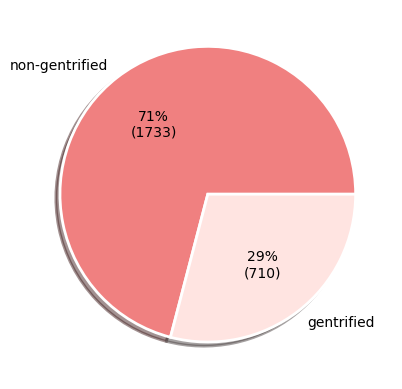

In [125]:
# concatenate into one dataframe for plotting
scores_all = pd.concat([scores_pre, scores_post], ignore_index=True)

# function for displaying counts and percentages
def autopct_format(values):
        def my_format(pct):
                total = sum(values)
                val = int(round(pct*total/100.0))
                return '{:.0f}%\n({v:d})'.format(pct, v=val)
        return my_format

# plot
values = scores_all['label'].value_counts().values
plt.pie(values,
        labels = scores_all['label'].value_counts().index,
        colors = ['lightcoral', 'mistyrose'],
        autopct = autopct_format(values), shadow = True,
        wedgeprops = {'linewidth': 2, 'edgecolor':'white'});

There is class imbalance in the data, with the gentrified facades accounting for just 29% of the dataset. Nonetheless, since the task is to extract attributes from the images and not classfiy gentrified/non-gentrified facades, this imbalance does not affect the reliability of the analyses. Moreover, given that the images *are sampled at random???*, this more or less represents people's true visual perception of gentrification in Amsterdam, where roughly 30% of facades are seen as gentrified.

#### Rewrite image folders
For the analysis, it is necessary that the images are separated per their labels. This would make it easier to extract and compare results between gentrified and non-gentrified storefronts. Therefore, based on the new label columns, the images are re-categorized into corresponding folders.

Before the images can be moved, their IDs in the label data frames and their file names need to be modified to align to each other:

In [152]:
# Pre-July 2020 images - Modifying the file names to match the IDs in label df
for file in glob.glob("images/img_pre/*.jpg"):
    img_filename = os.path.split(file)[1]
    img_id = str(int(img_filename.split('-')[0]))
    print(file, '------', img_id)
    # os.rename(file, os.path.join('images/img_pre/', img_id+'.jpg'))

images/img_pre/000001363-2019-Amsterdam-Javastraat--.jpg ------ 1363
images/img_pre/000000832-2009-Amsterdam-Kinkerstraat-52_3663625-4_8691562.jpg ------ 832
images/img_pre/000000973-2009-Amsterdam-Van_Woustraat-52_3567676-4_8997816.jpg ------ 973
images/img_pre/000001677-2019-Amsterdam-Van_Woustraat--.jpg ------ 1677
images/img_pre/000000064-2008-Amsterdam-Amstelveenseweg-52_3568465-4_8547238.jpg ------ 64
images/img_pre/000001600-2019-Amsterdam-Tussen_Meer-52_3572877-4_7957829.jpg ------ 1600
images/img_pre/000000935-2009-Amsterdam-Van_Woustraat-52_3551146-4_9010737.jpg ------ 935
images/img_pre/000000346-2008-Amsterdam-Spaarndammerstraat-52_3913402-4_8781085.jpg ------ 346
images/img_pre/000001637-2019-Amsterdam-Tussen_Meer-52_3586539-4_8026449.jpg ------ 1637
images/img_pre/000001163-2019-Amsterdam-Ceintuurbaan-52_3523686-4_8882219.jpg ------ 1163
images/img_pre/000001313-2019-Amsterdam-Eerste_van_Swindenstraat--.jpg ------ 1313
images/img_pre/000000327-2008-Amsterdam-Spaarndammers

In [127]:
# Post-July 2020 images - Modifying the IDs in label df to match file names
scores_post['id'] = scores_post['id'].str.replace(':','-')
scores_post['id'] = scores_post['id'] + '.jpg'
scores_post

,id,yes,no,label
0,faillissementsdossier-24368214.jpg,0,1,non-gentrified
1,faillissementsdossier-33251073.jpg,5,74,non-gentrified
2,faillissementsdossier-60624485.jpg,0,20,non-gentrified
3,faillissementsdossier-63432250.jpg,34,56,non-gentrified
4,faillissementsdossier-63453428.jpg,66,9,gentrified
...,...,...,...,...
526,osm-node-7020259827.jpg,19,54,non-gentrified
527,osm-node-746910501.jpg,4,56,non-gentrified
528,osm-node-936580930.jpg,22,52,non-gentrified
529,osm-way-499929237.jpg,49,19,gentrified


In [117]:
class_names = list(scores_all.label.unique())
for name in class_names:
    os.makedirs(os.path.join(name))

In [ ]:
for name in class_names:
    for img in list(scores_all[scores_all['label'] == name]['id']):
        img_path = os.path.join('all_images', img)

### Images: 

* Size/Dimensions
* Aspect ratios (width/height)
* Avg width and height
* Resolution
* Colors

In relation to models' img size requirements

In [15]:
# for file in glob.glob("sample_imgs/*.jpg"):
image = Image.open('sample_imgs/000000174-2008-Amsterdam-Ceintuurbaan-52_3531562-4_8943619.jpg')
exifdata = image.getexif()
# iterating over all EXIF data fields
for tag_id in exifdata:
    # get the tag name, instead of human unreadable tag id
    tag = TAGS.get(tag_id, tag_id)
    data = exifdata.get(tag_id)
    # decode bytes 
    if isinstance(data, bytes):
        data = data.decode()
    print(f"{tag:25}: {data}")


ExifOffset               : 38
Orientation              : 1


In the new version, all images have size 760x760, while those in the old version vary in sizes (ranging from ... to ...). However, no resizing of the original images was done. This is because the interest of the project is to analyze text regions of the images, and thus will only look at these regions cropped out from the original images. Additionally, the framework to be used for detecting text regions (EasyOCR) does not require a specific image size.

Additionally, images in the older version has higher-resolution images. *[How to deal with this in modeling??]*

#### Visual analysis
Noted that there are plenty of instances where non-gentrified facades contain no signage - something that can be directly concluded.

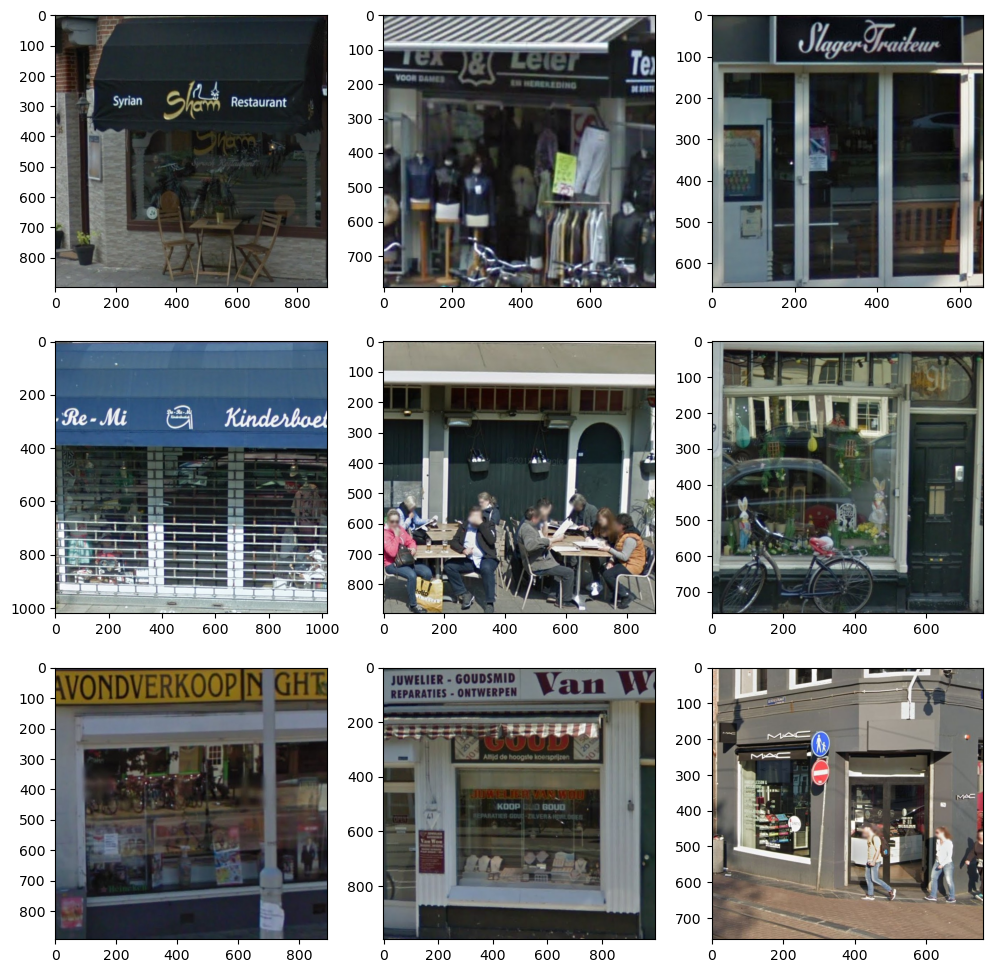

In [52]:
sample_img = [images[i] for i in np.random.randint(2441, size =(9))]

fig = plt.figure(figsize=(12,12))
rows, cols = 3, 3

# Display 12 random images
for i in range(0, cols*rows):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(sample_img[i])
plt.show()